In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

%matplotlib inline

# Load evaluation results

In [3]:
DATASET_NAMES = ["wine", "wine", "wine"]#, "census", "credit"]
EVAL_MODELS = dict([(dn+"{}".format(i), pd.read_csv("../out/eval/{}.csv".format(dn), sep=",")) for i, dn in enumerate(DATASET_NAMES)])
EVAL_METRICS = ["Accuracy", "F1 Macro", "ROC AUC"]

# Add <code>Accuracy</code> column

In [4]:
for dataset in EVAL_MODELS:
    eval_df = EVAL_MODELS[dataset]
    eval_df['Accuracy'] = 1 - eval_df['Binary Err Rate']
    colnames = eval_df.columns.tolist()
    new_colnames = colnames[:3] + [colnames[-1]] + colnames[3:-1]
    EVAL_MODELS[dataset] = eval_df[new_colnames]

# Normalize <code>Budget</code> values

In [5]:
for dataset in EVAL_MODELS:
    eval_df = EVAL_MODELS[dataset]
    eval_df['Budget Norm'] = round(eval_df['Budget']/eval_df['Budget'].max(), 2)
    colnames = eval_df.columns.tolist()
    new_colnames = colnames[:2] + [colnames[-1]] + colnames[2:-1]
    EVAL_MODELS[dataset] = eval_df[new_colnames]

# Plot GBDT vs. RF under attack

In [21]:
# #d11141 #00b159 #00aedb #f37735 #ffc425

def plot_standard(eval_df, dataset_name, eval_metrics, ax):
    sns.set_style("whitegrid")
    atk_budgets = eval_df['Budget Norm'].unique()
    #fig, ax = plt.subplots(1, 1, figsize=(6,6))
    palette = ['#d11141', '#00b159'] #, '#00aedb', '#f37735', '#ffc425', '#8874a3']
    palette = ['#00aedb', '#d11141']
    ls = ['-', '--']
    markers=['^', 's', 'o']
    for i, metric in enumerate(eval_metrics):
        _ = sns.lineplot(x="Budget Norm", 
                        y=metric, 
                        hue="Model",
                        markers=[markers[i], markers[i]],
                        style="Model",
                        style_order=["GBDT", "Random Forest"],
                        palette=palette, #[i*2:i*2+2],
                        data=eval_df[(eval_df['Model']=='GBDT') | (eval_df['Model']=='Random Forest')],
                        markersize=12,
                        ax=ax)
        #_ = ax.set_xlabel("attacker's budget", fontsize=18, labelpad=12)
        #_ = ax.set_ylabel("metric", fontsize=18, labelpad=12)
        _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
        _ = ax.set_title(dataset_name, fontsize=22)
        legend_elements = [Line2D([0], [0], color='#00aedb', lw=2),
                           Line2D([0], [0], color='#d11141', lw=2, ls="--"),
                           Line2D([0], [0], color='black', lw=1, marker="^", markersize=8), #, mew=3),
                           Line2D([0], [0], color='black', lw=1, marker="s", markersize=8),
                           Line2D([0], [0], color='black', lw=1, marker="o", markersize=8)
                          ]
        
        leg = ax.legend(title='Models', 
                      loc='best', 
                      handles=legend_elements, 
                     labels=['GBDT', 'Random Forest', 'Accuracy', 'F1 Macro', 'ROC AUC'],
                      borderpad=1,
                      fontsize=16)
        leg.get_title().set_fontsize(16)

In [22]:
def plot_all_standard(eval_dict, eval_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,8))
    i = 0
    for dataset_name in eval_dict:
        print("Plotting GBDT vs. RF under attack for dataset `{}`...".format(dataset_name))
        plot_standard(eval_dict[dataset_name], dataset_name, eval_metrics, axes[i])
        axes[i].set_xlabel("attacker's budget", fontsize=20, labelpad=12)
        if i == 0:
            axes[i].set_ylabel("metric", fontsize=20, labelpad=12)
        i += 1
    plt.tight_layout(pad=2.5)

Plotting GBDT vs. RF under attack for dataset `wine0`...
Plotting GBDT vs. RF under attack for dataset `wine1`...
Plotting GBDT vs. RF under attack for dataset `wine2`...


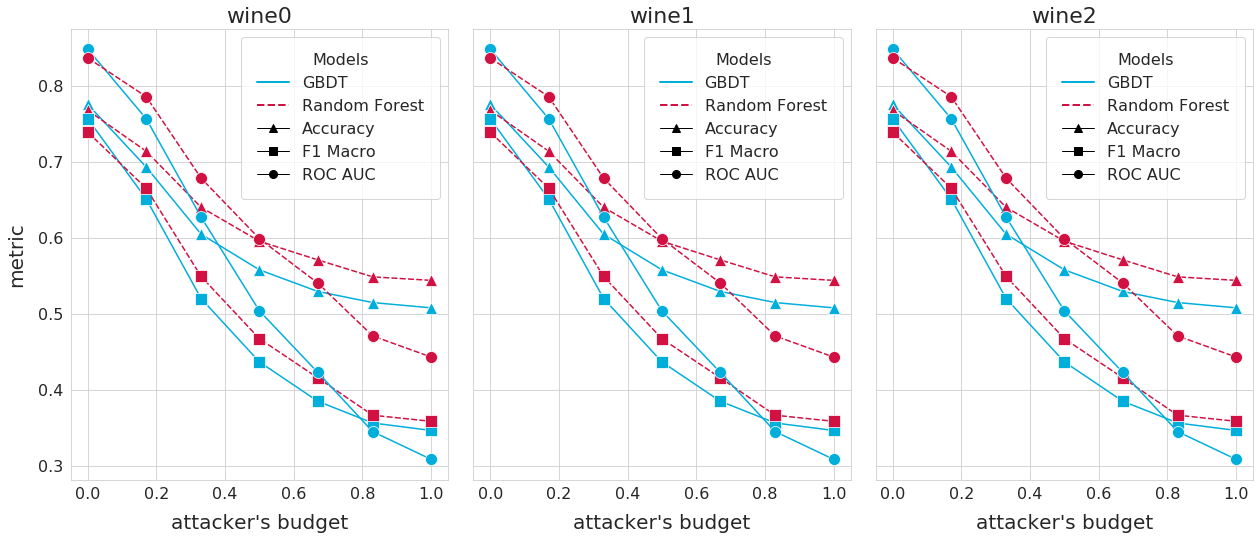

In [23]:
plot_all_standard(EVAL_MODELS, EVAL_METRICS)

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(6,8))
ax = sns.lineplot(x="Budget", 
                  y="Accuracy", 
                  hue="Model", 
                  style="Model",
                  markers=True,
                  palette=['#cf3721','cyan'], 
                  data=eval_df[(eval_df['Model']=='GBDT') | (eval_df['Model']=='Random Forest')])
ax = sns.lineplot(x="Budget", 
                  y="F1 Macro", 
                  hue="Model",
                  style="Model",
                  markers=True,
                  data=eval_df[(eval_df['Model']=='GBDT') | (eval_df['Model']=='Random Forest')])
ax = sns.lineplot(x="Budget", 
                  y="Roc Auc", 
                  hue="Model",
                  style="Model",
                  markers=True,
                  data=eval_df[(eval_df['Model']=='GBDT') | (eval_df['Model']=='Random Forest')])

legend_elements = [Line2D([0], [0], color='b', lw=4),
                   Line2D([0], [0], color='orange', lw=4),
                   Line2D([0], [0], color='black', lw=4, ls='dashed')
                  ]

_ = ax.legend(title='Metrics', loc='best', handles=legend_elements, labels=['GBDT', 'Random Forest', 'ciao'])
#plt.show(g)


In [ ]:
mask = eval_df.Model == "Baseline [GBDT]"
eval_df.loc[mask, 'Model'] = "GBDT"

In [ ]:
def rename_model(df, model_str, budget):
    mask = eval_df.Model == model_str.format(budget)
    df.loc[mask, 'Model'] = "Adversarial-Training [b={}]".format(budget)

In [ ]:
model_str = "Non-Interferent [b={}]"

for b in ATTACK_BUDGETS:
    rename_model(eval_df, model_str, b)

# Plot data

In [ ]:
def bar_plot_under_attack(df, metric, train_budget):

    fig, ax = plt.subplots(1, 1, figsize=(4,5.5))
    plt.ylim(.5,.75)
    
    models = ["GBDT", 
              "Adversarial-Boosting [b={}]".format(train_budget), 
              "Adversarial-Training [b={}]".format(train_budget)]

    data = df[df["Model"].isin(models)].filter(regex=("Model|Budget|"+metric))
    
    palette={'GBDT': '#cf3721',
                             "Adversarial-Boosting [b={}]".format(train_budget): '#31a9b8', #'#f5be41',
                             "Adversarial-Training [b={}]".format(train_budget): '#258039'
                            }

    _ = sns.barplot(x="Budget", y=metric, hue="Model", data=data, ax=ax)
    _ = ax.set_xlabel("test budget", fontsize=22, labelpad=12)
    ylabel = metric
    if metric == "F1":
        ylabel = "$F_1\ score$"
    _ = ax.set_ylabel(ylabel, fontsize=22, labelpad=6)
    start, end = ax.get_ylim()
    _ = ax.yaxis.set_ticks(np.arange(start, end, 0.1))
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    _ = ax.legend(loc='lower center', borderaxespad=0.2, fontsize=14)

    
#     handles, labels = ax[i].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='best', borderaxespad=0.5, fontsize=14) #bbox_to_anchor=(1.05, 1), loc=2

In [ ]:
sns.set_style("whitegrid")
for i, b in enumerate(ATTACK_BUDGETS):
    bar_plot_under_attack(eval_df, "F1", b)

In [ ]:
def precision_recall(df, train_budget, att_budget):

    fig, ax = plt.subplots(1, 1, figsize=(4,5.5))
    #plt.title("Training budget = {} / Testing budget = {}".format(train_budget, att_budget), fontsize=16, pad=12)
    
    models = ["GBDT", 
              "Adversarial-Boosting [b={}]".format(train_budget), 
              "Adversarial-Training [b={}]".format(train_budget)]
    

    data = df[df["Model"].isin(models)].filter(regex=("Model|Budget|Precision|Recall"))

    _ = data[data.Budget == att_budget].plot(x="Budget", y=["Precision", "Recall"], kind="bar", ax=ax, color=['#31a9b8', '#cf3721'])
    _ = ax.set_xticklabels(["GBDT", 
                            "Adv-Boosting", "Adv-Training",
                           ], rotation=45
                          )
    _ = ax.set_xlabel("Models", fontsize=22, labelpad=12)
    _ = ax.set_xlabel("")
    ylabel = "Precision / Recall"
    _ = ax.set_ylabel(ylabel, fontsize=22, labelpad=6)
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    _ = ax.legend(loc='lower center', borderaxespad=0.5, fontsize=18)

In [ ]:
import itertools
from operator import itemgetter

b = [0] + ATTACK_BUDGETS
c = list(itertools.product(b, b))
pairs = sorted(c, key=itemgetter(0,1))
pairs

In [ ]:
sns.set_style("whitegrid")
for tb, ab in pairs:
    if (tb == ab and tb != 0) or (tb != 0 and ab == 0):
        precision_recall(eval_df, tb, ab)

# Figure 1

In [ ]:
# Figure
plt.figure(figsize=(12,8))

# sns.pointplot(x="N. of Trees", y="ROC AUC Under Max Attack", hue="Model", 
#                   data=eval_df, ax=ax, palette="OrRd", 
#                   markers=['s', '*', '*', '*', '*', '*', '*', 'o'], 
#                   linestyles=['-', '-', '-', '-', '-', '-', '-', '-']
#                  )

################## ROC AUC ##################

plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Full-Non-Interferent"], 
         eval_df["ROC AUC"][eval_df['Model']=="Full-Non-Interferent"], 
         color='#258039', marker='s', ms=10, mfc='None', label=r"Full Non-Interferent [$\alpha=1.00$]")

# plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.50]"], 
#          eval_df["ROC AUC"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.50]"], 
#          color='#31a9b8', marker='x', ms=10, mfc='None', label="Weighted-Non-Interferent [alpha=0.50]")

# plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.10]"], 
#          eval_df["ROC AUC"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.10]"], 
#          color='#f5be41', marker='D', ms=10, mfc='None', label="Weighted-Non-Interferent [alpha=0.10]")

plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Baseline [p=1.0; n=max]"], 
         eval_df["ROC AUC"][eval_df['Model']=="Baseline [p=1.0; n=max]"], 
         color='#cf3721', marker='o', ms=10,  mfc='None', label=r"Adversarial Boosting [$n = \max$]")

################## ROC AUC Under Max Attack ##################

plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Full-Non-Interferent"], 
         eval_df["ROC AUC Under Max Attack"][eval_df['Model']=="Full-Non-Interferent"], 
         color='#258039', marker='s',  ms=10,  label=r"Full Non-Interferent [$\alpha=1.00$] (under attack)")

# plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.50]"], 
#          eval_df["ROC AUC Under Max Attack"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.50]"], 
#          color='#31a9b8', marker='x', ms=10,  label="Weighted-Non-Interferent [alpha=0.50] (under attack)")

# plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.10]"], 
#          eval_df["ROC AUC Under Max Attack"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.10]"], 
#          color='#f5be41', marker='D',  ms=10,  label="Weighted-Non-Interferent [alpha=0.10] (under attack)")

plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Baseline [p=1.0; n=max]"], 
         eval_df["ROC AUC Under Max Attack"][eval_df['Model']=="Baseline [p=1.0; n=max]"], 
         color='#cf3721', marker='o',  ms=10, label=r"Adversarial Boosting [$n = \max$] (under attack)")


#plt.xlim([0,210])
plt.xticks(range(0,210,50))

plt.legend(loc="best", borderaxespad=0.5, fontsize=14) #bbox_to_anchor=(1.05, 1), loc=2
plt.title("$AUC$ / $AUC^A$ on varying number of trees", fontsize=20)
plt.xlabel("N. of Trees", fontsize=20, labelpad=12)
plt.ylabel("$AUC$ / $AUC^A$", fontsize=20, labelpad=6)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.grid()
plt.savefig(ATTACKER+"_roc_auc_trees.pdf")

In [ ]:
# Figure
plt.figure(figsize=(12,8))

# sns.pointplot(x="N. of Trees", y="ROC AUC Under Max Attack", hue="Model", 
#                   data=eval_df, ax=ax, palette="OrRd", 
#                   markers=['s', '*', '*', '*', '*', '*', '*', 'o'], 
#                   linestyles=['-', '-', '-', '-', '-', '-', '-', '-']
#                  )

################## ROC AUC ##################

# plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Full-Non-Interferent"], 
#          eval_df["ROC AUC"][eval_df['Model']=="Full-Non-Interferent"], 
#          color='#258039', marker='s', ms=10, mfc='None', label=r"Full Non-Interferent [$\alpha=1.00$]")

# plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.50]"], 
#          eval_df["ROC AUC"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.50]"], 
#          color='#f5be41', marker='X', ms=10, mfc='None', label=r"Weighted Non-Interferent [$\alpha=0.50$]")

# plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.10]"], 
#          eval_df["ROC AUC"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.10]"], 
#          color='#31a9b8', marker='D', ms=10, mfc='None', label=r"Weighted Non-Interferent [$\alpha=0.10$]")

# plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Baseline [p=1.0; n=max]"], 
#          eval_df["ROC AUC"][eval_df['Model']=="Baseline [p=1.0; n=max]"], 
#          color='#cf3721', marker='o', ms=10,  mfc='None', label=r"Adversarial Boosting [$n = \max$]")

################## ROC AUC Under Max Attack ##################

plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Full-Non-Interferent"], 
         eval_df["ROC AUC Under Max Attack"][eval_df['Model']=="Full-Non-Interferent"], 
         color='#258039', marker='s',  ms=10,  label=r"Full Non-Interferent [$\alpha=1.00$]")

plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.50]"], 
         eval_df["ROC AUC Under Max Attack"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.50]"], 
         color='#f5be41', marker='X', ms=10,  label=r"Weighted Non-Interferent [$\alpha=0.50$]")

plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.10]"], 
         eval_df["ROC AUC Under Max Attack"][eval_df['Model']=="Weighted-Non-Interferent [alpha=0.10]"], 
         color='#31a9b8', marker='D',  ms=10,  label=r"Weighted Non-Interferent [$\alpha=0.10$]")

plt.plot(eval_df["N. of Trees"][eval_df['Model']=="Baseline [p=1.0; n=max]"], 
         eval_df["ROC AUC Under Max Attack"][eval_df['Model']=="Baseline [p=1.0; n=max]"], 
         color='#cf3721', marker='o',  ms=10, label=r"Adversarial Boosting [$n = \max$]")


#plt.xlim([0,210])
plt.xticks(range(0,210,50))

plt.legend(loc="best", borderaxespad=0.5, fontsize=14) #bbox_to_anchor=(1.05, 1), loc=2
plt.title("$AUC^A$ on varying number of trees", fontsize=20)
plt.xlabel("N. of Trees", fontsize=20, labelpad=12)
plt.ylabel("$AUC^A$", fontsize=20, labelpad=6)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.grid()
plt.savefig(ATTACKER+"_roc_auc_trees_alpha.pdf")
#plt.savefig("unattacked_roc_auc_trees_alpha.pdf")

AttributeError: 'ErrorbarContainer' object has no attribute 'plot'

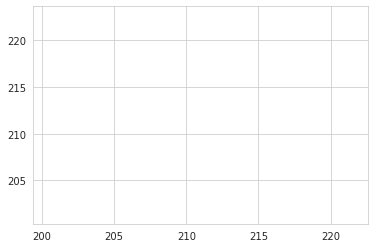

In [29]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import numpy as np

data = pandas.DataFrame({"x": [1, 2, 4],
                        "y": [10,20,40],
                        "s": [10,10,10]}) # I increased your errors so I could see them

# Create a figure instance, and the two subplots
fig = plt.figure()
ax1 = plt.errorbar(211,212)
#ax2 = fig.add_subplot(212)

# Tell pointplot to plot on ax1 with the ax argument
sns.pointplot(x="x", y="y", data=data, ax=ax1)

# Plot the errorbar directly on ax1
ax1.errorbar(np.arange(len(data["x"])), data["y"], yerr=data["s"])

# Tell the factorplot to plot on ax2 with the ax argument
# Also store the FacetGrid in 'g'
g=sns.factorplot(x="x", y="y", data=data, ax=ax2)

# Close the FacetGrid figure which we don't need (g.fig)
plt.close(g.fig)

plt.show()
